In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# 2. Results B2.0
Evaluation of the annotations of the train set for task B2

### 1. Import Results
Results created under the same fingerprint are saved in a CSV file for each seed. All results are combined into one dataset.

In [2]:
#B1.0
path_B2 = 'STRING_RESULT_TRAIN/B2.0/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_7917.csv')


In [3]:
# Combine all dataframes into one
B2_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [4]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B2 = B2_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B2.shape

(800, 6)

In [5]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B2['unique_id'].unique().tolist()

In [6]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [7]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score    support
egalitarian                   0.794118  0.627907  0.701299   43.00000
general normative statement   0.571429  0.347826  0.432432   23.00000
libertarian                   0.000000  0.000000  0.000000    1.00000
prioritarian                  0.777778  0.760870  0.769231   46.00000
sufficientarian               0.444444  0.666667  0.533333    6.00000
utilitarian                   0.614035  0.853659  0.714286   41.00000
accuracy                      0.681250  0.681250  0.681250    0.68125
macro avg                     0.533634  0.542821  0.525097  160.00000
weighted avg                  0.693186  0.681250  0.674826  160.00000


Classification Report for S2
                             precision    recall  f1-score  support
egalitarian                   0.729730  0.627907  0.675000   43.000
general normative statement   0.562500  0.391304  0.461538   23.000
libertarian                   0.0000

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [11]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
def principle_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B2_consistency = filtered_B2.groupby('unique_id').filter(principle_y_not_uniform)

B2_consistency.shape

(115, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [12]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B2.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B2_grouped = filtered_B2.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B2_grouped

,unique_id,text,PRINCIPLE_x,llm_query,iteration,PRINCIPLE_y
0,107,Typhoon Haiyan has once again gravely reminded...,utilitarian,107 Typhoon Haiyan has once again gravely remi...,1,utilitarian
1,125,"We urge, all parties here in Warsaw to take de...",prioritarian,"125 We urge, all parties here in Warsaw to tak...",1,egalitarian
2,126,"We believe that, Nationally Appropriate Mitiga...",prioritarian,"126 We believe that, Nationally Appropriate Mi...",1,egalitarian
3,130,"We must also take decisions on finance, techno...",general normative statement,"130 We must also take decisions on finance, te...",1,utilitarian
4,131,We urge parties to take decisions on simplific...,prioritarian,131 We urge parties to take decisions on simpl...,1,egalitarian
...,...,...,...,...,...,...
155,1089,"Adequate and predictable funding, structured f...",prioritarian,"1089 Adequate and predictable funding, structu...",1,prioritarian
156,1090,We call upon the developed countries that have...,prioritarian,1090 We call upon the developed countries that...,1,prioritarian
157,1092,We must educate our citizens about climate cha...,general normative statement,1092 We must educate our citizens about climat...,1,utilitarian
158,1093,We must view climate education as an investmen...,utilitarian,1093 We must view climate education as an inve...,1,utilitarian


In [13]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B2_grouped['PRINCIPLE_x'],filtered_B2_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.75      0.63      0.68        43
general normative statement       0.56      0.39      0.46        23
                libertarian       0.00      0.00      0.00         1
               prioritarian       0.79      0.74      0.76        46
            sufficientarian       0.40      0.67      0.50         6
                utilitarian       0.63      0.83      0.72        41

                   accuracy                           0.68       160
                  macro avg       0.52      0.54      0.52       160
               weighted avg       0.69      0.68      0.67       160



(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'egalitarian'),
  Text(1, 0, 'GNS'),
  Text(2, 0, 'libertarian'),
  Text(3, 0, 'prioritarian'),
  Text(4, 0, 'sufficientarian'),
  Text(5, 0, 'utilitarian')])

<Figure size 8000x8000 with 0 Axes>

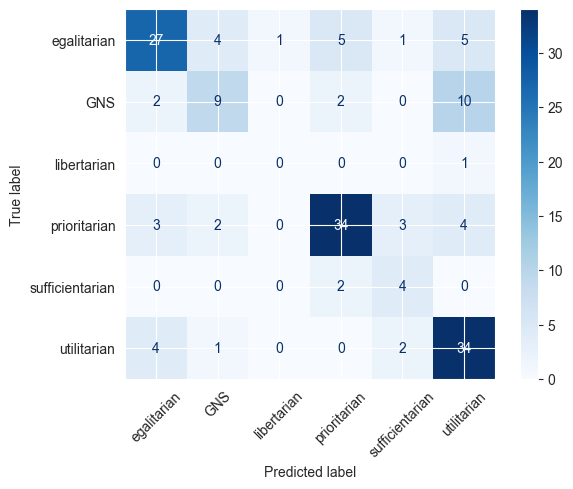

In [14]:
# Evaluate confusionmatrix for this aggregated set
labels = ['egalitarian', 'GNS', 'libertarian','prioritarian', 'sufficientarian', 'utilitarian']

plt.figure(figsize=(80, 80))
cm = confusion_matrix(filtered_B2_grouped['PRINCIPLE_x'],filtered_B2_grouped['PRINCIPLE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis and y-axis tick labels
plt.xticks(rotation=45)

-------------------------------------------------------

# 2. Results B2.1 - FP1!

### 1. Import Results
Results created under the same fingerprint are saved in a CSV file for each seed. All results are combined into one dataset.

In [16]:
#B1.0
path_B21 = 'STRING_RESULT/B2.1/all_iterations_138'

# Open all dataframes
S1 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_7917.csv')


In [17]:
# Combine all dataframes into one
B21_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [18]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B21 = B21_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B21.shape

(690, 6)

In [19]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B21['unique_id'].unique().tolist()

In [20]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [21]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score    support
egalitarian                   0.478261  0.458333  0.468085   24.00000
general normative statement   0.428571  0.391304  0.409091   23.00000
libertarian                   1.000000  1.000000  1.000000    1.00000
prioritarian                  0.777778  0.777778  0.777778   45.00000
sufficientarian               1.000000  0.600000  0.750000    5.00000
utilitarian                   0.711111  0.800000  0.752941   40.00000
accuracy                      0.659420  0.659420  0.659420    0.65942
macro avg                     0.732620  0.671236  0.692982  138.00000
weighted avg                  0.657825  0.659420  0.655875  138.00000


Classification Report for S2
                             precision    recall  f1-score     support
egalitarian                   0.434783  0.416667  0.425532   24.000000
general normative statement   0.391304  0.391304  0.391304   23.000000
libertarian                

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [39]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
def principle_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B21_consistency = filtered_B21.groupby('unique_id').filter(principle_y_not_uniform)

B21_consistency.shape

(115, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [37]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B21.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B21_grouped = filtered_B21.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B21_grouped

,unique_id,text,PRINCIPLE_x,llm_query,iteration,PRINCIPLE_y
0,3,Mr. President: A fair and effective framewor...,utilitarian,3 Mr. President: A fair and effective framew...,1,egalitarian
1,5,Such a framework must be based on “nationally ...,egalitarian,5 Such a framework must be based on “nationall...,1,general normative statement
2,44,It should not only enable us to discuss global...,utilitarian,44 It should not only enable us to discuss glo...,1,utilitarian
3,53,Global warming is a catastrophic problem that ...,utilitarian,53 Global warming is a catastrophic problem th...,1,utilitarian
4,54,"Therefore, the multilateralism approach remain...",general normative statement,"54 Therefore, the multilateralism approach rem...",1,general normative statement
...,...,...,...,...,...,...
213,1172,As we work to catch up on lost time and progr...,prioritarian,1172 As we work to catch up on lost time and ...,1,prioritarian
214,1173,"Conflict -ridden communities, refugees, and d...",prioritarian,"1173 Conflict -ridden communities, refugees, ...",1,prioritarian
215,1174,"Nor can we stand by , as the massive destructi...",utilitarian,"1174 Nor can we stand by , as the massive dest...",1,prioritarian
216,1198,We recognise that we must deliver on our coll...,prioritarian,1198 We recognise that we must deliver on our...,1,prioritarian


In [38]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B21_grouped['PRINCIPLE_x'],filtered_B21_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.71      0.57      0.63        51
general normative statement       0.45      0.42      0.44        33
                libertarian       0.50      1.00      0.67         1
               prioritarian       0.81      0.82      0.81        66
            sufficientarian       0.46      0.75      0.57         8
                utilitarian       0.67      0.73      0.70        59

                   accuracy                           0.67       218
                  macro avg       0.60      0.71      0.64       218
               weighted avg       0.68      0.67      0.67       218



(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'egalitarian'),
  Text(1, 0, 'GNS'),
  Text(2, 0, 'libertarian'),
  Text(3, 0, 'prioritarian'),
  Text(4, 0, 'sufficientarian'),
  Text(5, 0, 'utilitarian')])

<Figure size 8000x8000 with 0 Axes>

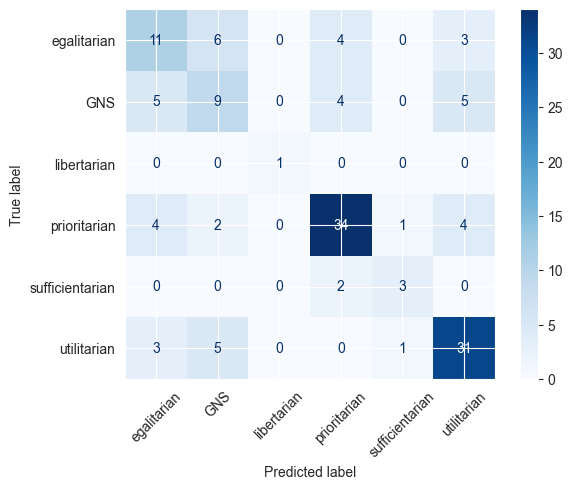

In [25]:
# Evaluate confusionmatrix for this aggregated set
labels = ['egalitarian', 'GNS', 'libertarian','prioritarian', 'sufficientarian', 'utilitarian']

plt.figure(figsize=(80, 80))
cm = confusion_matrix(filtered_B21_grouped['PRINCIPLE_x'],filtered_B21_grouped['PRINCIPLE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis and y-axis tick labels
plt.xticks(rotation=45)

# 2. Results B2.1 - FP2!

### 1. Import Results
Results created under the same fingerprint are saved in a CSV file for each seed. All results are combined into one dataset.

In [26]:
#B1.0
path_B21 = 'STRING_RESULT/B2.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_7917.csv')


In [27]:
# Combine all dataframes into one
B21_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [28]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B21 = B21_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B21.shape

(1090, 6)

In [29]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B21['unique_id'].unique().tolist()

In [30]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [31]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score     support
egalitarian                   0.690476  0.568627  0.623656   51.000000
general normative statement   0.451613  0.424242  0.437500   33.000000
libertarian                   0.500000  1.000000  0.666667    1.000000
prioritarian                  0.805970  0.818182  0.812030   66.000000
sufficientarian               0.461538  0.750000  0.571429    8.000000
utilitarian                   0.666667  0.711864  0.688525   59.000000
accuracy                      0.669725  0.669725  0.669725    0.669725
macro avg                     0.596044  0.712153  0.633301  218.000000
weighted avg                  0.673565  0.669725  0.668344  218.000000


Classification Report for S2
                             precision    recall  f1-score     support
egalitarian                   0.763158  0.568627  0.651685   51.000000
general normative statement   0.444444  0.484848  0.463768   33.000000
libertarian      

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [32]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
def principle_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B21_consistency = filtered_B21.groupby('unique_id').filter(principle_y_not_uniform)

B21_consistency

,unique_id,text,PRINCIPLE_x,llm_query,PRINCIPLE_y,iteration
21,125,"We urge, all parties here in Warsaw to take de...",prioritarian,"125 We urge, all parties here in Warsaw to tak...",egalitarian,1
22,126,"We believe that, Nationally Appropriate Mitiga...",prioritarian,"126 We believe that, Nationally Appropriate Mi...",egalitarian,1
31,139,"In addition, major developing countries must a...",general normative statement,"139 In addition, major developing countries mu...",egalitarian,1
35,148,The Holy See’s Delegation has repeatedly calle...,egalitarian,148 The Holy See’s Delegation has repeatedly c...,utilitarian,1
45,173,The Holy Sce hopes that everyone will join in ...,utilitarian,173 The Holy Sce hopes that everyone will join...,utilitarian,1
...,...,...,...,...,...,...
1079,1123,Jamaica urges developed nations to fulfill the...,general normative statement,1123 Jamaica urges developed nations to fulfil...,prioritarian,1
1082,1135,We encourage all nations to adopt a similar ap...,egalitarian,1135 We encourage all nations to adopt a simil...,egalitarian,1
1083,1139,"Let us rise above our differences, unite in pu...",egalitarian,"1139 Let us rise above our differences, unite ...",egalitarian,1
1087,1174,"Nor can we stand by , as the massive destructi...",utilitarian,"1174 Nor can we stand by , as the massive dest...",prioritarian,1



In combined dataframe, groupyby unique ID and take the majority label

In [33]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B21.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B21_grouped = filtered_B21.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B21_grouped

,unique_id,text,PRINCIPLE_x,llm_query,iteration,PRINCIPLE_y
0,3,Mr. President: A fair and effective framewor...,utilitarian,3 Mr. President: A fair and effective framew...,1,egalitarian
1,5,Such a framework must be based on “nationally ...,egalitarian,5 Such a framework must be based on “nationall...,1,general normative statement
2,44,It should not only enable us to discuss global...,utilitarian,44 It should not only enable us to discuss glo...,1,utilitarian
3,53,Global warming is a catastrophic problem that ...,utilitarian,53 Global warming is a catastrophic problem th...,1,utilitarian
4,54,"Therefore, the multilateralism approach remain...",general normative statement,"54 Therefore, the multilateralism approach rem...",1,general normative statement
...,...,...,...,...,...,...
213,1172,As we work to catch up on lost time and progr...,prioritarian,1172 As we work to catch up on lost time and ...,1,prioritarian
214,1173,"Conflict -ridden communities, refugees, and d...",prioritarian,"1173 Conflict -ridden communities, refugees, ...",1,prioritarian
215,1174,"Nor can we stand by , as the massive destructi...",utilitarian,"1174 Nor can we stand by , as the massive dest...",1,prioritarian
216,1198,We recognise that we must deliver on our coll...,prioritarian,1198 We recognise that we must deliver on our...,1,prioritarian


In [34]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B21_grouped['PRINCIPLE_x'],filtered_B21_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.71      0.57      0.63        51
general normative statement       0.45      0.42      0.44        33
                libertarian       0.50      1.00      0.67         1
               prioritarian       0.81      0.82      0.81        66
            sufficientarian       0.46      0.75      0.57         8
                utilitarian       0.67      0.73      0.70        59

                   accuracy                           0.67       218
                  macro avg       0.60      0.71      0.64       218
               weighted avg       0.68      0.67      0.67       218



(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'egalitarian'),
  Text(1, 0, 'GNS'),
  Text(2, 0, 'libertarian'),
  Text(3, 0, 'prioritarian'),
  Text(4, 0, 'sufficientarian'),
  Text(5, 0, 'utilitarian')])

<Figure size 8000x8000 with 0 Axes>

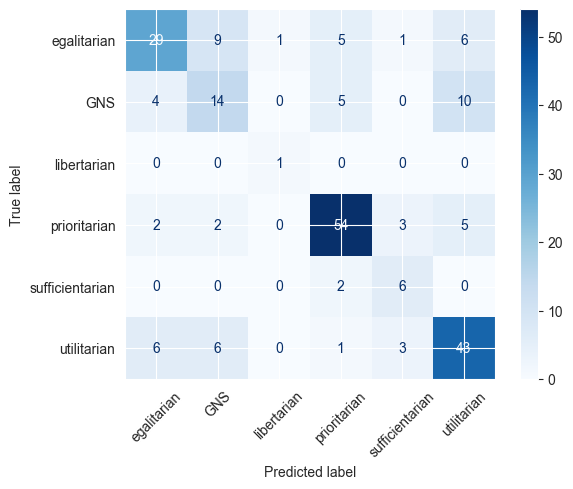

In [35]:
# Evaluate confusionmatrix for this aggregated set
labels = ['egalitarian', 'GNS', 'libertarian','prioritarian', 'sufficientarian', 'utilitarian']

plt.figure(figsize=(80, 80))
cm = confusion_matrix(filtered_B21_grouped['PRINCIPLE_x'],filtered_B21_grouped['PRINCIPLE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis and y-axis tick labels
plt.xticks(rotation=45)